In [2]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import os
import sys
import pickle
# Add the function directory to the path
sys.path.append('/home/jiarong/research/postprocessing/jupyter_notebook/functions/')
from Slicing import Slicing
from fio import readin
from TurStat import TurStat
from tqdm import tqdm
from visualization import contour_generator

In [111]:
from scipy.interpolate import LinearNDInterpolator, griddata
import matplotlib.gridspec as gridspec
def eta_readin(time,linear=True):
    global dirname 
    N = 64
    xarray = np.linspace(-np.pi,np.pi,N,endpoint=False)+np.pi/N; zarray = np.linspace(-np.pi,np.pi,N,endpoint=False)+np.pi/N
    x_tile, z_tile = np.meshgrid(xarray,zarray)
    eta_series = np.zeros((time.size,N,N), dtype=np.float32)
    for i,t in enumerate(time):
        filename = dirname + 'eta_t%g' % t
        snapshot = pd.read_table(filename, delimiter = ',')
        # Interpolate over x-z plane
        xdata = np.array(snapshot.x); zdata = np.array(snapshot.z); etadata = np.array(snapshot.pos)
        if linear:
            eta_tile = griddata((xdata.ravel(), zdata.ravel()), etadata.ravel(), (x_tile, z_tile), method='linear')
        else:
            eta_tile = griddata((xdata.ravel(), zdata.ravel()), etadata.ravel(), (x_tile, z_tile), method='linear')
        eta_series[i] = eta_tile
    return eta_series
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.5_ak0.1_LEVEL9_thinlayer/' 
time =np.arange(55,75,0.1) 
# axis0-time,axis1-z,axis2-x
eta_series_linear = eta_readin(time)

In [110]:
dirname = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.2_ak0.1_LEVEL9_thinlayer/' 
time =np.arange(55,75,1) 
# axis0-time,axis1-z,axis2-x
eta_series_linear = eta_readin(time)

FileNotFoundError: File b'/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_region_RE10000_Ustar0.2_ak0.1_LEVEL9_thinlayer/eta_t55' does not exist

In [133]:
data = eta_series_linear[:,:,:]-1
N = 64
dt = 0.1    # sampling frequency, (Hz)
dx = 2*np.pi/N     # spatial sampling step along X in (m)
dy = 2*np.pi/N     # spatial sampling step along Y in (m)
t_max = dt * data.shape[0]  # s
x_max = dx * data.shape[1]  # m
y_max = dy * data.shape[2]  # m
x = np.linspace(0, x_max, data.shape[1])   # m
y = np.linspace(0, y_max, data.shape[2])   # m
xx,yy = np.meshgrid(x, y, indexing='ij')
omega = np.linspace(-np.pi / dt, np.pi / dt, data.shape[0], endpoint=False)                          # frequency (Hz)
kx = np.linspace(-np.pi / dx, np.pi / dx, data.shape[1], endpoint=False)  # wavenumber along X axis (rad/mm)
ky = np.linspace(-np.pi / dy, np.pi / dy, data.shape[2], endpoint=False)  # wavenumber along Y axis (rad/mm)
Ky, Kx = np.meshgrid(ky, kx, indexing='ij')
Omega, K = np.meshgrid(omega, kx, indexing='ij')

In [138]:
print(np.average(data))

-1.4549692e-05


Text(0, 0.5, 'kz')

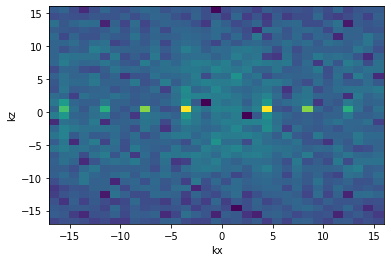

In [139]:
b = 15
spectrum_2d = np.fft.fftn(data[50,:,:])
spectrum_2d = np.fft.fftshift(spectrum_2d, axes=(0,1))
F_2d = np.absolute(spectrum_2d)
# plt.pcolormesh(Kx, Ky, F_2d)
F_2d = np.log(F_2d)
plt.pcolormesh(Kx[b:-b,b:-b], Ky[b:-b,b:-b], F_2d[b:-b,b:-b])
plt.xlabel('kx')
plt.ylabel('kz')

In [102]:
np.average(data)

0.9999877

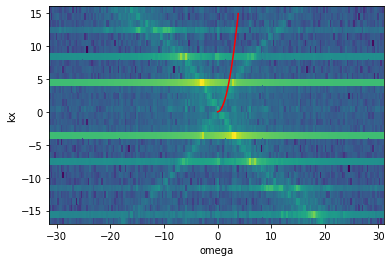

In [146]:
# time seris of eta (axis0=time, axis1=)
b = 15
spectrum_3d = np.fft.fftn(data)
spectrum_3d = np.fft.fftshift(spectrum_3d, axes=(0,1,2))
F = np.absolute(spectrum_3d)
F = np.log(F)
F_aver = np.average(F,axis=1)
plt.pcolormesh(Omega[:,b:-b], K[:,b:-b], F[:,32,b:-b])
# plt.pcolormesh(Omega[:,b:-b], K[:,b:-b], F_aver[:,b:-b])
plt.xlabel('omega')
plt.ylabel('kx')
plt.ylim = [kx[0],kx[-1]]
kx = np.arange(0,15,0.1)
omega = (kx)**0.5 
plt.plot(omega,kx,'r')

In [ ]:
# The 2D case
path = '/home/jiarong/research/projects/windwave/linlog/' + \
        'wavewind_real_linlog_ve_coarser_waves4L00.25Ustar0.6ak0.1BoReLEVEL11REGION0.05/'
def interface(time):
    global common_path, L0
    etafile = common_path + '/field/eta%g' %time
    eta, exists = readin(etafile, table_delimiter = ',')
    if exists:
        eta.rename(columns={'pos':'eta'}, inplace=True)
        ampl = Amplitude(eta[['x', 'eta', 'f']], 512, L0)   
    return ampl